# Tracking Research Data and Software in OpenAIRE

This script analyses how OpenAIRE indexes research data and software produced by authors affiliated to the VU over the past five years. 

The goal is to explore metadata coverage, quality, and relationships to better understand how these outputs are represented in open infrastructures.

In [59]:
import re
import os
import ast
import glob
import json
import time
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from rapidfuzz import fuzz, process

## Research datasets

### 1. Data collection and cleaning

In [60]:
#ACCESS_TOKEN = ""

HEADERS = {
    "accept": "application/json",
#    "Authorization": f"Bearer {ACCESS_TOKEN}"
}

# Get VU organization ID
org_url = "https://api.openaire.eu/graph/v1/organizations"
params = {"pid": "https://ror.org/008xxew50"}
response = requests.get(org_url, headers=HEADERS, params=params)
response.raise_for_status()
org_id = response.json()["results"][0]["id"]

# Paginate by year using valid date filters
datasets = []
for year in range(2020, 2025):
    print(f"\nRetrieving datasets from year {year}...")
    page = 1
    while True:
        print(f"  Fetching page {page} of {year}...")
        url = "https://api.openaire.eu/graph/v2/researchProducts"
        params = {
            "relOrganizationId": org_id,
            "type": "dataset",
            "fromPublicationDate": f"{year}-01-01",
            "toPublicationDate": f"{year}-12-31",
            "page": page,
            "pageSize": 100
        }
        response = requests.get(url, headers=HEADERS, params=params)
        if response.status_code != 200:
            print(f"Failed on page {page} of {year} (Status {response.status_code})")
            break

        results = response.json().get("results", [])
        if not results:
            break

        datasets.extend(results)
        page += 1
        time.sleep(0.5)

print(f"\nRetrieved {len(datasets)} total datasets across years.")

# Saving results
df = pd.json_normalize(datasets)
df.to_csv("openaire_datasets_vu_2020_2024.csv", index=False)


Retrieving datasets from year 2020...
  Fetching page 1 of 2020...
  Fetching page 2 of 2020...
  Fetching page 3 of 2020...
  Fetching page 4 of 2020...
  Fetching page 5 of 2020...
  Fetching page 6 of 2020...
  Fetching page 7 of 2020...
  Fetching page 8 of 2020...

Retrieving datasets from year 2021...
  Fetching page 1 of 2021...
  Fetching page 2 of 2021...
  Fetching page 3 of 2021...
  Fetching page 4 of 2021...
  Fetching page 5 of 2021...
  Fetching page 6 of 2021...
  Fetching page 7 of 2021...
  Fetching page 8 of 2021...
  Fetching page 9 of 2021...
  Fetching page 10 of 2021...
  Fetching page 11 of 2021...
  Fetching page 12 of 2021...
  Fetching page 13 of 2021...

Retrieving datasets from year 2022...
  Fetching page 1 of 2022...
  Fetching page 2 of 2022...
  Fetching page 3 of 2022...
  Fetching page 4 of 2022...
  Fetching page 5 of 2022...
  Fetching page 6 of 2022...
  Fetching page 7 of 2022...
  Fetching page 8 of 2022...
  Fetching page 9 of 2022...
  Fetchin

In [61]:
# Normalize title and find duplicates
def normalize_title(title):
    if isinstance(title, str):
        return title.strip().lower()
    return ""

def exclude_fig_titles(title):
    if isinstance(title, str):
        return not bool(re.search(r'\bfig \d+\b', title.strip().lower()))
    return False

def collect_duplicates(df, title_col, detail_cols, authors_col):
    df = df.copy()
    df['normalized_title'] = df[title_col].apply(normalize_title)
    df = df[df['normalized_title'].apply(lambda x: (x != "") and (pd.notna(x)) and exclude_fig_titles(x))]

    duplicate_titles = df['normalized_title'].value_counts()
    duplicate_titles = duplicate_titles[duplicate_titles > 1].index

    duplicate_df = df[df['normalized_title'].isin(duplicate_titles)].sort_values('normalized_title')

    grouped_output = []
    for norm_title in duplicate_titles:
        group = duplicate_df[duplicate_df['normalized_title'] == norm_title]
        for _, row in group.iterrows():
            details = " | ".join(str(row[col]) for col in detail_cols if col in row)
            grouped_output.append({
                "normalized_title": norm_title,
                "original_title": row[title_col],
                "details": details,
                "authors": row[authors_col]
            })
        grouped_output.append({})
    
    return pd.DataFrame(grouped_output), len(duplicate_titles)


openaire_duplicate_df, openaire_duplicate_count = collect_duplicates(
    df=df,
    title_col='mainTitle',
    detail_cols=['id', 'publisher', 'publicationDate'],
    authors_col = 'authors'
)


openaire_duplicate_df.to_csv("duplicates_df.csv", index=False)
print("Number of duplicate titles found:", openaire_duplicate_count)

print(openaire_duplicate_df.normalized_title.value_counts())

# Clean/normalize authors
def get_openaire_authors(row):
    if row is None or (isinstance(row, float) and pd.isna(row)):
        return tuple()
    if isinstance(row, str):
        try:
            row = json.loads(row)
        except json.JSONDecodeError:
            return tuple()
    if isinstance(row, list):
        names = [
            author.get('fullName', '').strip()
            for author in row
            if isinstance(author, dict) and 'fullName' in author
        ]
        return tuple(sorted(name for name in names if name))
    return tuple()


# Compare authors per title
def check_same_authors(df):
    df['authors_clean'] = df['authors'].apply(get_openaire_authors)
    same_authors_map = (
        df.groupby('normalized_title')['authors_clean']
          .apply(lambda g: len(set(g)) == 1)
    )
    df['same_authors'] = df['normalized_title'].map(same_authors_map)
    summary_df = (
        df.groupby('normalized_title', as_index=False)
          .agg({
              'authors_clean': lambda x: list(set(x)),
              'same_authors': 'first'
          })
    )
    return summary_df

summary_df = check_same_authors(openaire_duplicate_df)
display(summary_df.head(10))

# Filter duplicates and keep one
def filter_duplicates_and_keep_one(df, duplicate_titles, title_col):
    df['normalized_title'] = df[title_col].apply(normalize_title)
    df_filtered = df[df['normalized_title'].isin(duplicate_titles)].drop_duplicates(subset=['normalized_title'], keep='first')
    df_non_duplicates = df[~df['normalized_title'].isin(duplicate_titles)]
    df_combined = pd.concat([df_filtered, df_non_duplicates]).sort_index()
    return df_combined

duplicate_titles_openaire = openaire_duplicate_df['normalized_title'].unique()
clean_openaire_df_full = filter_duplicates_and_keep_one(df, duplicate_titles_openaire, title_col='mainTitle')

print(f"Before cleaning: {df.shape[0]}")
print(f"After cleaning: {clean_openaire_df_full.shape[0]}")


Number of duplicate titles found: 18
datation d'un support de peinture                                                                                                                                       232
replication data for chapter 5                                                                                                                                            6
replication data for chapter 3                                                                                                                                            5
replication data for chapter 2                                                                                                                                            3
replication data for: chapter 3                                                                                                                                           3
replication data for chapter 4                                                                         

,normalized_title,authors_clean,same_authors
0,"a double-blind, placebo-controlled, randomized...","[(Adams, David, Amato, Anthony, Attarian, Shah...",False
1,an approach using performance models for suppo...,"[(Daniele Di Pompeo, Ivano Malavolta, Luigi Po...",False
2,datation d'un support de peinture,"[(Fraiture, PF,)]",True
3,example data and python script,[()],True
4,lc-uv chromatograms,"[(Arrahman, Arif, Kazandjian, Taline D., Kool,...",False
5,officegraph,"[(VolkerWessels, van der Weerdt, Roderick), (G...",False
6,ok <> jökull memorial shirt,"[(schäfer, s†ëf∆n,), (Schäfer, Stefan,)]",False
7,replication data for chapter 2,"[(Collazos, Maria Antonieta,), (De Salvo, Carm...",False
8,replication data for chapter 3,"[(Nsanzumuhire, Silas,), (Soares Martins Neto,...",False
9,replication data for chapter 4,"[(Soares Martins Neto, Antonio,), (De Salvo, C...",False


Before cleaning: 5606
After cleaning: 5348


In [62]:
# Missing value inspection
def missing_value_summary(df, name="Dataset"):
    total = df.isnull().sum()
    percent = (df.isnull().mean() * 100).round(2)
    missing_df = pd.DataFrame({
        'Missing Count': total,
        'Missing %': percent
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)
    return missing_df

openaire_missing = missing_value_summary(clean_openaire_df_full, name="OpenAIRE")

display(openaire_missing)


,Missing Count,Missing %
contactPeople,5348,100.00
container,5348,100.00
isInDiamondJournal,5348,100.00
isGreen,5348,100.00
lastUpdateTimeStamp,5348,100.00
dateOfCollection,5348,100.00
geoLocations,5348,100.00
tools,5348,100.00
contactGroups,5348,100.00
openAccessColor,5348,100.00


In [63]:
# Even if we selected the VU organization, some datasets may not be correctly linked to NL as a country
openaire_non_nl_df = clean_openaire_df_full[clean_openaire_df_full['countries'].apply(
    lambda x: not any(country['code'] == 'NL' for country in x) if isinstance(x, list) else True
)]
print(f"Number of rows where countries do not contain NL: {openaire_non_nl_df.shape[0]}")


Number of rows where countries do not contain NL: 1129


### 2. Investigating links with other research products

In [64]:
# Getting PIDs to retrieve the links
def get_schemes(pids):
    try:
        if isinstance(pids, str):
            pids = ast.literal_eval(pids)
        return [pid.get("scheme") for pid in pids if isinstance(pid, dict)]
    except Exception:
        return []

all_schemes = clean_openaire_df_full["pids"].apply(get_schemes).explode().dropna()
scheme_counts = Counter(all_schemes)

print("Available PID schemes:")
for scheme, count in scheme_counts.items():
    print(f"  {scheme}: {count}")

# To avoid redundancy, extract the best PID per preferred order
def extract_best_pid(pids):
    try:
        if isinstance(pids, str):
            pids = ast.literal_eval(pids)

        preferred_order = ["doi", "handle", "pmid", "ark", "arxiv", "url"] 

        for scheme in preferred_order:
            for pid in pids:
                if isinstance(pid, dict) and pid.get("scheme") == scheme:
                    return {"id": pid.get("value"), "scheme": scheme}

        for pid in pids:
            if isinstance(pid, dict) and "value" in pid and "scheme" in pid:
                return {"id": pid.get("value"), "scheme": pid.get("scheme")}

    except Exception:
        pass

    return None

clean_openaire_df_full["pid_info"] = clean_openaire_df_full["pids"].apply(extract_best_pid)

clean_openaire_df_full["pid_value"] = clean_openaire_df_full["pid_info"].apply(lambda x: x["id"] if isinstance(x, dict) else None)
clean_openaire_df_full["pid_scheme"] = clean_openaire_df_full["pid_info"].apply(lambda x: x["scheme"] if isinstance(x, dict) else None)

pid_list = clean_openaire_df_full[["pid_value", "pid_scheme"]].dropna().drop_duplicates().to_dict("records")


Available PID schemes:
  doi: 6617
  mag_id: 307
  handle: 11
  pmid: 2


In [ ]:
# Query OpenAIRE links API in batches
url = "https://api.openaire.eu/graph/v1/researchProducts/links"

BATCH_SIZE = 500
TIMEOUT = 30  # seconds per request
RETRIES = 3   # per DOI
SLEEP_BETWEEN = 1.0  # seconds between requests

headers = {"accept": "application/json"}

# Choose whether to look for links where your PID is a target or a source
mode = "targets"  # change to "sources" when needed
param_key = "targetPid" if mode == "targets" else "sourcePid"
file_prefix = "target" if mode == "targets" else "source"

link_results = []

start_batch_number = 1
batch_start_index = (start_batch_number - 1) * BATCH_SIZE
pid_list_remaining = pid_list[batch_start_index:]

# Batch processing
for batch_offset, batch_start in enumerate(range(0, len(pid_list_remaining), BATCH_SIZE)):
    batch_number = start_batch_number + batch_offset
    batch = pid_list_remaining[batch_start: batch_start + BATCH_SIZE]

    print(f"Processing batch {batch_number} "
          f"({batch_start_index + batch_start + 1}–"
          f"{batch_start_index + batch_start + len(batch)} of {len(pid_list)})\n")

    for i, pid_entry in enumerate(batch, start=1):
        pid_value = pid_entry["pid_value"]
        pid_scheme = pid_entry["pid_scheme"]

        print(f"Checking {batch_start_index + batch_start + i}/{len(pid_list)}: {pid_scheme}:{pid_value}")

        params = {param_key: pid_value, "page": 0, "pageSize": 100}

        # Retry logic
        for attempt in range(RETRIES):
            try:
                response = requests.get(url, headers=headers, params=params, timeout=TIMEOUT)
                if response.status_code == 200:
                    data = response.json()
                    links = data.get("results", [])
                    break
                else:
                    print(f"Response {response.status_code} on attempt {attempt + 1}")
                    links = []
            except requests.exceptions.Timeout:
                print(f"Timeout on attempt {attempt + 1}")
                links = []
            except requests.exceptions.RequestException as e:
                print(f"Request error: {e}")
                links = []
            time.sleep(5)  # pause before retry

        # Process results
        if links:
            print(f"Found {len(links)} link(s)")
            for link in links:
                link_data = {
                    "pid_value": pid_value,
                    "pid_scheme": pid_scheme,
                    "query_role": mode  # record whether it was queried as source or target
                }
                for key, value in link.items():
                    if isinstance(value, dict):
                        for nested_key, nested_value in value.items():
                            link_data[f"{key}_{nested_key}"] = nested_value
                    else:
                        link_data[key] = value
                link_results.append(link_data)
        else:
            print("No links found")

        time.sleep(SLEEP_BETWEEN)

    # Save batch results
    batch_df = pd.DataFrame(link_results)
    filename = f"openaire_linkage_{file_prefix}_batch_{batch_number}.csv"
    batch_df.to_csv(filename, index=False)
    print(f"Saved partial results to {filename}\n")

    link_results = []  # clear for next batch


In [66]:
# Set mode to "targets" or "sources" depending on which batch files you want to combine
mode = "targets"  # or "sources"

folder = "."
file_prefix = "target" if mode == "targets" else "source"

# Find all batch files for the chosen mode
files = sorted(
    glob.glob(os.path.join(folder, f"openaire_linkage_{file_prefix}_batch_*.csv")),
    key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split("_")[-1])
)

print(f"Found {len(files)} {mode} batch files to combine:")
for f in files:
    print("  ", os.path.basename(f))

# Read and concatenate all batches
if files:
    dfs = [pd.read_csv(f) for f in files]
    links_df = pd.concat(dfs, ignore_index=True)

    output_file = f"openaire_linkage_{file_prefix}_combined.csv"
    links_df.to_csv(output_file, index=False)
    print(f"Combined file saved as: {output_file}")
    print(f"Total records: {len(links_df)}")
else:
    print("No matching batch files found.")


Found 10 targets batch files to combine:
   openaire_linkage_target_batch_1.csv
   openaire_linkage_target_batch_2.csv
   openaire_linkage_target_batch_3.csv
   openaire_linkage_target_batch_4.csv
   openaire_linkage_target_batch_5.csv
   openaire_linkage_target_batch_6.csv
   openaire_linkage_target_batch_7.csv
   openaire_linkage_target_batch_8.csv
   openaire_linkage_target_batch_9.csv
   openaire_linkage_target_batch_10.csv
Combined file saved as: openaire_linkage_target_combined.csv
Total records: 8270


Average number of linked works per target DOI: 4.27
Target DOIs with linked works: 1938/4905 (39.5%)

Relationship types distribution:
references                      5826
cites                           1330
hasamongtopnsimilardocuments     857
haspart                          129
documents                         40
issupplementto                    23
hasversion                        18
issourceof                        13
describes                         10
isnewversionof                     8
compiles                           7
continues                          5
requires                           2
reviews                            1
ismetadataof                       1
Name: relType_name, dtype: int64

Source research product types:
publication    7538
dataset         660
software         50
other            22
Name: source_type, dtype: int64


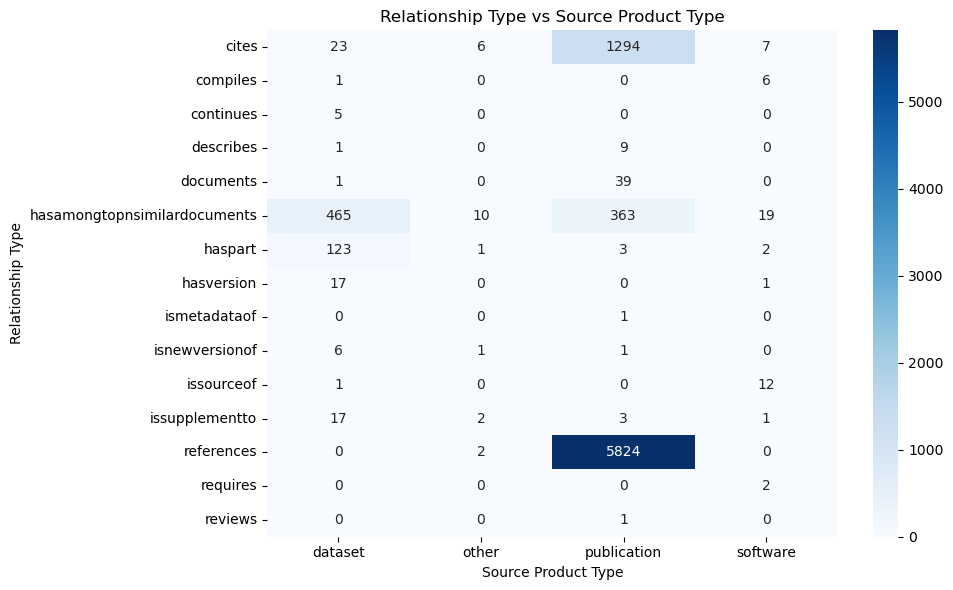

In [ ]:
# Determine the key column based on mode
pid_col = "target_identifiers" if mode == "targets" else "source_identifiers"

# How many links per PID on average?
linked_counts = links_df[pid_col].value_counts()
average_links_per_pid = linked_counts.mean()
print(f"Average number of linked works per {mode[:-1]} DOI: {average_links_per_pid:.2f}")

# What percentage of PIDs have at least one linked work?
total_pids_with_links = links_df[pid_col].nunique()
all_pids = [entry["pid_value"] for entry in pid_list]
total_expected = len(all_pids)
pids_with_links = len(set(links_df[pid_col]) & set(all_pids))
percent_with_links = (pids_with_links / total_expected) * 100
print(f"{mode[:-1].capitalize()} DOIs with linked works: {pids_with_links}/{total_expected} ({percent_with_links:.1f}%)")

# Distribution of relationship types
relationship_counts = links_df['relType_name'].value_counts()
print("\nRelationship types distribution:")
print(relationship_counts)

# Distribution of source types
source_type_counts = links_df['source_type'].value_counts()
print("\nSource research product types:")
print(source_type_counts)

# Heatmap: relationship type vs source product type
rel_source_crosstab = pd.crosstab(links_df['relType_name'], links_df['source_type'])

plt.figure(figsize=(10, 6))
sns.heatmap(rel_source_crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Relationship Type vs Source Product Type')
plt.ylabel('Relationship Type')
plt.xlabel('Source Product Type')
plt.tight_layout()
plt.show()


### 3. Exploratory analysis

In [68]:
# 1. Open Access
print("Open Access Label Distribution:")
print(clean_openaire_df_full['bestAccessRight.label'].value_counts(dropna=False))

# 2. Publication Year
def extract_year(date):
    if pd.isna(date): return None
    try:
        return int(str(date)[:4])
    except:
        return None

clean_openaire_df_full['year'] = clean_openaire_df_full['publicationDate'].apply(extract_year)

print("Publication Year Distribution:")
print(clean_openaire_df_full['year'].value_counts().sort_index())

# 3. Hosting Data Source Frequency
print("Hosting Data Sources (via Publisher):")
clean_openaire_df_full['publisher'].dropna().value_counts()

# 4. Topics
def get_openaire_subjects(df):
    all_subjects = []
    for _, row in df.iterrows():
        if 'subjects' in row and isinstance(row['subjects'], list):
            for subject in row['subjects']:
                if 'subject' in subject and 'value' in subject['subject']:
                    all_subjects.append(subject['subject']['value'])
    return all_subjects

openaire_subjects = get_openaire_subjects(clean_openaire_df_full)
subject_counts = Counter(openaire_subjects)
print(subject_counts.most_common(15))

# 5. Citations
print(clean_openaire_df_full['indicators.citationImpact.citationCount'].describe())
# Number of datasets with at least one citation
print(clean_openaire_df_full[clean_openaire_df_full['indicators.citationImpact.citationCount']>0].shape[0])


Open Access Label Distribution:
OPEN          4194
NaN            625
RESTRICTED     497
CLOSED          32
Name: bestAccessRight.label, dtype: int64
Publication Year Distribution:
2020     671
2021     877
2022    1187
2023     994
2024    1619
Name: year, dtype: int64
Hosting Data Sources (via Publisher):
[('Life Sciences', 1919), ('Social and Behavioural Sciences', 1856), ('Social Sciences', 1602), ('Agriculture, Forestry, Horticulture, Aquaculture and Veterinary Medicine', 1524), ('Agriculture, Forestry, Horticulture, Aquaculture', 1524), ('Soil Sciences', 1509), ('Humanities', 629), ('Arts and Humanities', 623), ('Other', 587), ('Medicine, Health and Life Sciences', 503), ('Medicine', 495), ('Natural Sciences', 490), ('Health and Life Sciences', 487), ('3. Good health', 467), ('Earth and Environmental Sciences', 427)]
count    5348.000000
mean        0.049738
std         0.307250
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.0000

## Research Software

### 1. Data collection and cleaning

In [69]:
sw = []
for year in range(2020, 2025):
    print(f"\nRetrieving software from year {year}...")
    page = 1
    while True:
        print(f"  Fetching page {page} of {year}...")
        url = "https://api.openaire.eu/graph/v1/researchProducts"
        params = {
            "relOrganizationId": org_id,
            "type": "software",
            "fromPublicationDate": f"{year}-01-01",
            "toPublicationDate": f"{year}-12-31",
            "page": page,
            "pageSize": 100
        }
        response = requests.get(url, headers=HEADERS, params=params)
        if response.status_code != 200:
            print(f"Failed on page {page} of {year} (Status {response.status_code})")
            break

        results = response.json().get("results", [])
        if not results:
            break

        sw.extend(results)
        page += 1
        time.sleep(0.5)

print(f"\nRetrieved {len(sw)} total software across years.")

sw_df_openaire = pd.json_normalize(sw)
sw_df_openaire.to_csv("openaire_software_vu_2020_2024.csv", index=False)



Retrieving software from year 2020...
  Fetching page 1 of 2020...
  Fetching page 2 of 2020...

Retrieving software from year 2021...
  Fetching page 1 of 2021...
  Fetching page 2 of 2021...

Retrieving software from year 2022...
  Fetching page 1 of 2022...
  Fetching page 2 of 2022...

Retrieving software from year 2023...
  Fetching page 1 of 2023...
  Fetching page 2 of 2023...

Retrieving software from year 2024...
  Fetching page 1 of 2024...
  Fetching page 2 of 2024...

Retrieved 301 total software across years.


In [74]:
# Normalize title and find duplicates
openaire_duplicate_sw, openaire_duplicate_sw_count = collect_duplicates(
    df=sw_df_openaire,
    title_col='mainTitle',
    detail_cols=['id', 'publisher', 'publicationDate'],
    authors_col = 'authors'
)


openaire_duplicate_sw.to_csv("duplicates_sw.csv", index=False)
print("Number of duplicate titles found:", openaire_duplicate_sw_count)

print(openaire_duplicate_sw.normalized_title.value_counts())

# Clean/normalize authors
summary_sw = check_same_authors(openaire_duplicate_sw)
display(summary_sw.head(10))

# Filter duplicates and keep one
duplicate_titles_sw = openaire_duplicate_sw['normalized_title'].unique()
clean_openaire_sw_full = filter_duplicates_and_keep_one(sw_df_openaire, duplicate_titles_sw, title_col='mainTitle')

print(f"Before cleaning: {sw_df_openaire.shape[0]}")
print(f"After cleaning: {clean_openaire_sw_full.shape[0]}")


Number of duplicate titles found: 7
lilio: calendar generator for machine learning with timeseries data    3
the community inversion framework: codes and documentation             2
s2spy                                                                  2
tribler/tribler: v7.11.0-rc1                                           2
spicypy                                                                2
tribler/tribler: v7.14.0                                               2
metadraft release: 0.9.5                                               2
Name: normalized_title, dtype: int64


,normalized_title,authors_clean,same_authors
0,lilio: calendar generator for machine learning...,"[(Kalverla, Peter, Liu, Yang, Schilperoort, Ba...",False
1,metadraft release: 0.9.5,"[(Mendoza, Sebasti��n, Molenaar, Douwe, Olivie...",False
2,s2spy,"[(Alidoost, Fakhereh, Donnelly, Claire, Kalver...",False
3,spicypy,"[(Bania, Saurav, Basalaev, Artem, Chalathadka ...",False
4,the community inversion framework: codes and d...,"[(Adrien Berchet, Antoine BERCHET, Audrey Fort...",False
5,tribler/tribler: v7.11.0-rc1,"[(Alexander Kozlovsky, Andrei Andreev, António...",True
6,tribler/tribler: v7.14.0,"[(Alexander Kozlovsky, Andrei Andreev, António...",True


Before cleaning: 301
After cleaning: 293


In [75]:
# Missing value inspection
openaire_missing_sw = missing_value_summary(clean_openaire_sw_full, name="OpenAIRE")
openaire_missing_sw

,Missing Count,Missing %
openAccessColor,293,100.00
codeRepositoryUrl,293,100.00
isInDiamondJournal,293,100.00
isGreen,293,100.00
lastUpdateTimeStamp,293,100.00
dateOfCollection,293,100.00
geoLocations,293,100.00
version,293,100.00
size,293,100.00
tools,293,100.00


In [76]:
# Filter rows where 'NL' is not present in the 'countries' column
openaire_non_nl_sw = clean_openaire_sw_full[clean_openaire_sw_full['countries'].apply(
    lambda x: not any(country['code'] == 'NL' for country in x) if isinstance(x, list) else True
)]

print(f"Number of rows where countries do not contain NL: {openaire_non_nl_sw.shape[0]}")


Number of rows where countries do not contain NL: 285


### 2. Investigating links with other research products

In [77]:
# Getting PIDs to retrieve the links
all_schemes = clean_openaire_sw_full["pids"].apply(get_schemes).explode().dropna()
scheme_counts = Counter(all_schemes)

print("Available PID schemes:")
for scheme, count in scheme_counts.items():
    print(f"  {scheme}: {count}")

# To avoid redundancy, extract the best PID per preferred order
def extract_best_pid(pids):
    try:
        if isinstance(pids, str):
            pids = ast.literal_eval(pids)

        preferred_order = ["doi", "handle", "pmid", "ark", "arxiv", "url"] 

        for scheme in preferred_order:
            for pid in pids:
                if isinstance(pid, dict) and pid.get("scheme") == scheme:
                    return {"id": pid.get("value"), "scheme": scheme}

        for pid in pids:
            if isinstance(pid, dict) and "value" in pid and "scheme" in pid:
                return {"id": pid.get("value"), "scheme": pid.get("scheme")}

    except Exception:
        pass

    return None

clean_openaire_sw_full["pid_info"] = clean_openaire_sw_full["pids"].apply(extract_best_pid)

clean_openaire_sw_full["pid_value"] = clean_openaire_sw_full["pid_info"].apply(lambda x: x["id"] if isinstance(x, dict) else None)
clean_openaire_sw_full["pid_scheme"] = clean_openaire_sw_full["pid_info"].apply(lambda x: x["scheme"] if isinstance(x, dict) else None)

pid_list_sw = clean_openaire_sw_full[["pid_value", "pid_scheme"]].dropna().drop_duplicates().to_dict("records")


Available PID schemes:
  doi: 624


In [81]:
# Query OpenAIRE links API in batches
url = "https://api.openaire.eu/graph/v1/researchProducts/links"

BATCH_SIZE = 500
TIMEOUT = 30  # seconds per request
RETRIES = 3   # per DOI
SLEEP_BETWEEN = 1.0  # seconds between requests

headers = {"accept": "application/json"}

# Choose whether to look for links where your PID is a target or a source
mode = "targets"  # change to "sources" when needed
param_key = "targetPid" if mode == "targets" else "sourcePid"
file_prefix = "target" if mode == "targets" else "source"

link_results = []

start_batch_number = 1
batch_start_index = (start_batch_number - 1) * BATCH_SIZE
pid_list_remaining = pid_list_sw[batch_start_index:]

# Batch processing
for batch_offset, batch_start in enumerate(range(0, len(pid_list_remaining), BATCH_SIZE)):
    batch_number = start_batch_number + batch_offset
    batch = pid_list_remaining[batch_start: batch_start + BATCH_SIZE]

    print(f"Processing batch {batch_number} "
          f"({batch_start_index + batch_start + 1}–"
          f"{batch_start_index + batch_start + len(batch)} of {len(pid_list_sw)})\n")

    for i, pid_entry in enumerate(batch, start=1):
        pid_value = pid_entry["pid_value"]
        pid_scheme = pid_entry["pid_scheme"]

        print(f"Checking {batch_start_index + batch_start + i}/{len(pid_list_sw)}: {pid_scheme}:{pid_value}")

        params = {param_key: pid_value, "page": 0, "pageSize": 100}

        # Retry logic
        for attempt in range(RETRIES):
            try:
                response = requests.get(url, headers=headers, params=params, timeout=TIMEOUT)
                if response.status_code == 200:
                    data = response.json()
                    links = data.get("results", [])
                    break
                else:
                    print(f"Response {response.status_code} on attempt {attempt + 1}")
                    links = []
            except requests.exceptions.Timeout:
                print(f"Timeout on attempt {attempt + 1}")
                links = []
            except requests.exceptions.RequestException as e:
                print(f"Request error: {e}")
                links = []
            time.sleep(5)  # pause before retry

        # Process results
        if links:
            print(f"Found {len(links)} link(s)")
            for link in links:
                link_data = {
                    "pid_value": pid_value,
                    "pid_scheme": pid_scheme,
                    "query_role": mode  # record whether it was queried as source or target
                }
                for key, value in link.items():
                    if isinstance(value, dict):
                        for nested_key, nested_value in value.items():
                            link_data[f"{key}_{nested_key}"] = nested_value
                    else:
                        link_data[key] = value
                link_results.append(link_data)
        else:
            print("No links found")

        time.sleep(SLEEP_BETWEEN)

    # Save batch results
    batch_df = pd.DataFrame(link_results)
    filename = f"openaire_linkage_sw_{file_prefix}_batch_{batch_number}.csv"
    batch_df.to_csv(filename, index=False)
    print(f"Saved partial results to {filename}\n")

    link_results = []  # clear for next batch


Processing batch 1 (1–287 of 287)

Checking 1/287: doi:10.5281/zenodo.4322372
Found 2 link(s)
Checking 2/287: doi:10.5281/zenodo.3633449
Found 2 link(s)
Checking 3/287: doi:10.5281/zenodo.3665811
No links found
Checking 4/287: doi:10.5281/zenodo.3825857
Found 1 link(s)
Checking 5/287: doi:10.5281/zenodo.3821165
Found 1 link(s)
Checking 6/287: doi:10.5281/zenodo.4454585
No links found
Checking 7/287: doi:10.5281/zenodo.3727494
No links found
Checking 8/287: doi:10.5281/zenodo.3667675
Found 2 link(s)
Checking 9/287: doi:10.5281/zenodo.3634367
No links found
Checking 10/287: doi:10.5281/zenodo.4291061
Found 4 link(s)
Checking 11/287: doi:10.5281/zenodo.3668316
Found 7 link(s)
Checking 12/287: doi:10.5281/zenodo.4327209
No links found
Checking 13/287: doi:10.5281/zenodo.3606813
Found 2 link(s)
Checking 14/287: doi:10.5281/zenodo.3751594
Found 1 link(s)
Checking 15/287: doi:10.5281/zenodo.4305914
Found 1 link(s)
Checking 16/287: doi:10.5281/zenodo.3661036
Found 1 link(s)
Checking 17/287: do

In [82]:
# Set mode to "targets" or "sources" depending on which batch files you want to combine
mode = "targets"  # or "sources"

folder = "."
file_prefix = "target" if mode == "targets" else "source"

# Find all batch files for the chosen mode
files = sorted(
    glob.glob(os.path.join(folder, f"openaire_linkage_sw_{file_prefix}_batch_*.csv")),
    key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split("_")[-1])
)

print(f"Found {len(files)} {mode} batch files to combine:")
for f in files:
    print("  ", os.path.basename(f))

# Read and concatenate all batches
if files:
    dfs = [pd.read_csv(f) for f in files]
    links_sw = pd.concat(dfs, ignore_index=True)

    output_file = f"openaire_linkage_sw_{file_prefix}_combined.csv"
    links_sw.to_csv(output_file, index=False)
    print(f"Combined file saved as: {output_file}")
    print(f"Total records: {len(links_sw)}")
else:
    print("No matching batch files found.")


Found 1 targets batch files to combine:
   openaire_linkage_sw_target_batch_1.csv
Combined file saved as: openaire_linkage_sw_target_combined.csv
Total records: 365


In [84]:
links_sw.head()

,pid_value,pid_scheme,query_role,source_identifiers,source_title,source_type,source_instanceType,source_publicationDate,source_authors,source_collectedFrom,target_identifiers,target_title,target_type,target_instanceType,target_publicationDate,target_authors,target_collectedFrom,relType_name,relType_typeSchema,provenance
0,10.5281/zenodo.4322372,doi,targets,"[{'id': '10.5281/zenodo.5045730', 'idScheme': ...",The Community Inversion Framework: codes and d...,software,Software,2021-06-30,"[{'name': 'Antoine BERCHET', 'identifiers': [{...","[{'name': 'ZENODO', 'identifiers': [{'id': '10...","[{'id': '10.5281/zenodo.4322372', 'idScheme': ...",The Community Inversion Framework: codes and d...,software,Software,2020-12-15,"[{'name': 'Antoine BERCHET', 'identifiers': [{...","[{'name': 'ZENODO', 'identifiers': [{'id': '10...",hasamongtopnsimilardocuments,datacite,['OpenAIRE']
1,10.5281/zenodo.4322372,doi,targets,"[{'id': '10.5281/zenodo.5045730', 'idScheme': ...",The Community Inversion Framework: codes and d...,software,Software,2021-06-30,"[{'name': 'Antoine BERCHET', 'identifiers': [{...","[{'name': 'ZENODO', 'identifiers': [{'id': '10...","[{'id': '10.5281/zenodo.4322372', 'idScheme': ...",The Community Inversion Framework: codes and d...,software,Software,2020-12-15,"[{'name': 'Antoine BERCHET', 'identifiers': [{...","[{'name': 'ZENODO', 'identifiers': [{'id': '10...",hasversion,datacite,"['Datacite', 'ZENODO']"
2,10.5281/zenodo.3633449,doi,targets,"[{'id': '10.5281/zenodo.1201316', 'idScheme': ...",Tribler/tribler: v7.14.0,software,Software,2024-04-24,"[{'name': 'Martijn de Vos', 'identifiers': []}...","[{'name': 'ZENODO', 'identifiers': [{'id': '10...","[{'id': '10.5281/zenodo.3633449', 'idScheme': ...",Tribler/tribler: V7.4.0,software,Software,2020-02-01,"[{'name': 'Martijn de Vos', 'identifiers': []}...","[{'name': 'ZENODO', 'identifiers': [{'id': '10...",hasversion,datacite,"['Datacite', 'ZENODO']"
3,10.5281/zenodo.3633449,doi,targets,"[{'id': '10.5281/zenodo.3557476', 'idScheme': ...",Tribler/tribler: V7.4.0-exp2,software,Software,2019-11-29,"[{'name': 'Martijn de Vos', 'identifiers': []}...","[{'name': 'ZENODO', 'identifiers': [{'id': '10...","[{'id': '10.5281/zenodo.3633449', 'idScheme': ...",Tribler/tribler: V7.4.0,software,Software,2020-02-01,"[{'name': 'Martijn de Vos', 'identifiers': []}...","[{'name': 'ZENODO', 'identifiers': [{'id': '10...",hasamongtopnsimilardocuments,datacite,['OpenAIRE']
4,10.5281/zenodo.3825857,doi,targets,"[{'id': '10.5281/zenodo.4749511', 'idScheme': ...",ci-group/revolve: Frontiers21constrained,software,Software,2021-05-11,"[{'name': 'Jelisavcic, Milan', 'identifiers': ...","[{'name': 'ZENODO', 'identifiers': [{'id': '10...","[{'id': '10.5281/zenodo.3825857', 'idScheme': ...",ci-group/revolve: Multiobjective Plasticoding,software,Software,2020-05-13,"[{'name': 'Milan Jelisavcic', 'identifiers': [...","[{'name': 'ZENODO', 'identifiers': [{'id': '10...",hasversion,datacite,"['Datacite', 'ZENODO']"


Average number of linked works per target DOI: 1.00
Target DOIs with linked works: 0/4905 (0.0%)

Relationship types distribution:
hasversion                      143
hasamongtopnsimilardocuments    127
cites                            88
issupplementto                    4
describes                         1
references                        1
continues                         1
Name: relType_name, dtype: int64

Source research product types:
software       249
publication    109
dataset          4
other            3
Name: source_type, dtype: int64


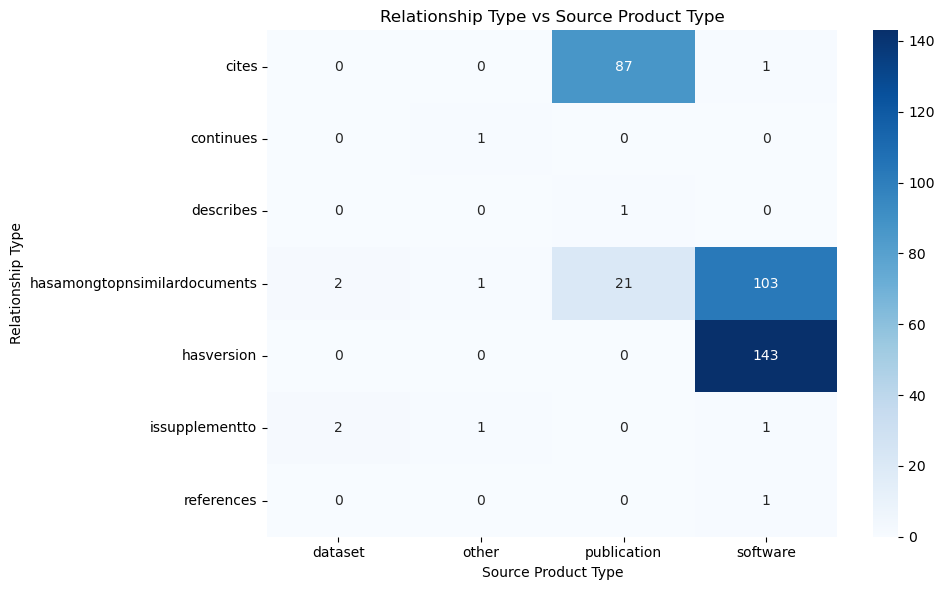

In [ ]:
# Determine the key column based on mode
pid_col = "target_identifiers" if mode == "targets" else "source_identifiers"

# How many links per PID on average?
linked_counts = links_sw[pid_col].value_counts()
average_links_per_pid = linked_counts.mean()
print(f"Average number of linked works per {mode[:-1]} DOI: {average_links_per_pid:.2f}")

# What percentage of PIDs have at least one linked work?
total_pids_with_links = links_sw[pid_col].nunique()
all_pids = [entry["pid_value"] for entry in pid_list]
total_expected = len(all_pids)
pids_with_links = len(set(links_sw[pid_col]) & set(all_pids))
percent_with_links = (pids_with_links / total_expected) * 100
print(f"{mode[:-1].capitalize()} DOIs with linked works: {pids_with_links}/{total_expected} ({percent_with_links:.1f}%)")

# Distribution of relationship types
relationship_counts = links_sw['relType_name'].value_counts()
print("\nRelationship types distribution:")
print(relationship_counts)

# Distribution of source types
source_type_counts = links_sw['source_type'].value_counts()
print("\nSource research product types:")
print(source_type_counts)

# Heatmap: relationship type vs source product type
rel_source_crosstab = pd.crosstab(links_sw['relType_name'], links_sw['source_type'])

plt.figure(figsize=(10, 6))
sns.heatmap(rel_source_crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Relationship Type vs Source Product Type')
plt.ylabel('Relationship Type')
plt.xlabel('Source Product Type')
plt.tight_layout()
plt.show()


### 3. Exploratory analysis

In [86]:
# 1. Open Access
print("Open Access Label Distribution:")
print(clean_openaire_sw_full['bestAccessRight.label'].value_counts(dropna=False))

# 2. Publication Year
clean_openaire_sw_full['year'] = clean_openaire_sw_full['publicationDate'].apply(extract_year)
print("Publication Year Distribution:")
print(clean_openaire_sw_full['year'].value_counts().sort_index())

# 3. Hosting Data Source Frequency
print("Hosting Data Sources (via Publisher):")
clean_openaire_sw_full['publisher'].dropna().value_counts()

# 4. Topics 
openaire_sw_subjects = get_openaire_subjects(clean_openaire_sw_full)
subject_counts = Counter(openaire_sw_subjects)
print(subject_counts.most_common(15))

# 5. Citations
print(clean_openaire_sw_full['indicators.citationImpact.citationCount'].describe())
# Number of datasets with at least one citation
print(clean_openaire_sw_full[clean_openaire_sw_full['indicators.citationImpact.citationCount']>0].shape[0])

Open Access Label Distribution:
NaN     160
OPEN    133
Name: bestAccessRight.label, dtype: int64
Publication Year Distribution:
2020    52
2021    37
2022    48
2023    65
2024    91
Name: year, dtype: int64
Hosting Data Sources (via Publisher):
[('13. Climate action', 12), ('neuroimaging', 9), ('workflow', 9), ('pipeline', 9), ('15. Life on land', 6), ('systems biology', 4), ('python', 4), ('Life Sciences', 4), ('Agriculture, Forestry, Horticulture, Aquaculture', 3), ('Agriculture, Forestry, Horticulture, Aquaculture and Veterinary Medicine', 3), ('11. Sustainability', 3), ('Social and Behavioural Sciences', 3), ('SBML', 2), ('3. Good health', 2), ('open science', 2)]
count    293.000000
mean       0.307167
std        1.469268
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       16.000000
Name: indicators.citationImpact.citationCount, dtype: float64
34
